In this lab you will do the following steps in order:

1. Load and parse text.
2. Train a LSTM network for single character generation.
3. Generate some text with the trained LSTM network.




Use GPU if available

In [1]:
import torch
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
device = torch.device("cuda:0" if train_on_gpu else "cpu")
print(device)

CUDA is available!  Training on GPU ...
cuda:0


In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import re

In [1]:
import matplotlib.pyplot as plt

def Print_loss(tst_loss = None, tr_loss = None, figsize = (10,8)):
    
    if tr_loss is None and tst_loss is None: 
        print("ERROR: no values are given")
        return 
    
    if tst_loss is None:
        x = np.arange(1,len(tr_loss)+1)
    else: 
        x = np.arange(1,len(tst_loss)+1)
        
    plt.figure(figsize = figsize)
    
    if tr_loss is not None:
        plt.plot(x,tr_loss, label = "training loss")
        print("Training loss minimum:",np.min(tr_loss))
    
    if tst_loss is not None:    
        plt.plot(x,tst_loss, label = "validation loss")
        print("Validation loss minimum:",np.min(tst_loss))
    
    plt.title("Loss vs epochs")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend()
    plt.grid(alpha=0.3)
    
    return 

1. load dataset

In [4]:
# Download the text file "Alice's Adventures in Wonderland" from Project Gutenberg
#!wget -O wonderland.txt https://www.gutenberg.org/ebooks/11.txt.utf-8

# Load the text data from the downloaded file
filename = "wonderland.txt"
with open(filename, 'r', encoding='utf-8') as f:
  raw_text = f.read()

# Convert all characters to lowercase
raw_text = raw_text.lower()

# Remove non-alphanumeric characters
raw_text = re.sub(r'\n', ' ', raw_text)
raw_text = re.sub(r'[^A-Za-z ]+', '', raw_text)

print(raw_text[500:700])
# Create a set of unique characters in the text
unique_chars = set(raw_text)

# Sort the unique characters
chars = sorted(list(unique_chars))

# Create a dictionary mapping each unique character to a unique integer
char_to_int = dict((c, i) for i, c in enumerate(chars))

# Split the text into training and testing sets
train_start = int(len(raw_text) * 0.1)  # Starting index for training set (10% of text)
train_end = int(len(raw_text) * 0.8)  # Ending index for training set (80% of text)
test_start = train_end  # Starting index for testing set (remaining 20% of text)

raw_text_train = raw_text[train_start:train_end]  # Extract training text
raw_text_test = raw_text[test_start:]  # Extract testing text

# Calculate and print some summary statistics
n_chars_train = len(raw_text_train)
n_chars_test = len(raw_text_test)
n_vocab = len(chars)

print("Total Characters train:", n_chars_train)
print("Total Characters test:", n_chars_test)
print("Total Unique Characters (Vocabulary Size):", n_vocab)
print("Chars: ",chars)

ok  title alices adventures in wonderland  author lewis carroll  release date june   ebook                  most recently updated february    language english  credits arthur dibianca and david widger
Total Characters train: 108293
Total Characters test: 30941
Total Unique Characters (Vocabulary Size): 27
Chars:  [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Prepare the dataset of input to output pairs encoded as integers.

The model takes input sequences of 100 characters and predicts the character 101

In [5]:
# Define the sequence length for character prediction
seq_length = 100

# List to store sequences of characters as integer indices
dataX = []

# List to store target characters (next character) as integer indices
dataY = []

# Loop through the training text with a stride of 1 character
for i in range(0, n_chars_train - seq_length, 1):
  # Extract an input sequence of length 'seq_length' from the training text
  seq_in = raw_text_train[i:i + seq_length]

  # Extract the target character (next character to predict)
  seq_out = raw_text_train[i + seq_length]

  # Convert characters in the input sequence to their integer indices using the mapping dictionary
  dataX.append([char_to_int[char] for char in seq_in])

  # Append the target character's integer index to the output list
  dataY.append(char_to_int[seq_out])

# Count the total number of training patterns (sequences-target character pairs)
n_patterns = len(dataX)
print("Total Patterns train: ", n_patterns)

# Convert the lists of integer indices (dataX and dataY) into PyTorch tensors
X_train = torch.tensor(dataX, dtype=torch.float32)
y_train = torch.tensor(dataY)

# Reshape the input sequences into a 3D tensor with dimensions:
#   - n_patterns: Number of training patterns
#   - seq_length: Length of the input sequence
#   - 1: Number of features (one-hot encoded characters can be represented as floats here)
X_train = X_train.reshape(n_patterns, seq_length, 1)

# Normalize the input sequences by dividing each element by the vocabulary size
# This helps the training process of the model
X_train = X_train / float(n_vocab)

# Prepare testing data (similar to training data preparation)

y_train = torch.tensor(dataY)

#test
dataX = []
dataY = []
for i in range(0, n_chars_test - seq_length, 1):
    seq_in = raw_text_test[i:i + seq_length]
    seq_out = raw_text_test[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])
n_patterns = len(dataX)
print("Total Patterns test: ", n_patterns)
# Convert the testing data lists to tensors, reshape, normalize, and create target tensor
X_test = torch.tensor(dataX, dtype=torch.float32).reshape(n_patterns, seq_length, 1)
X_test = X_test / float(n_vocab)
y_test = torch.tensor(dataY)


Total Patterns train:  108193
Total Patterns test:  30841


2. LSTM Model definition.

[LSTM](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html#torch.nn.LSTM)

[Explain](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)

[Multi layers](https://www.researchgate.net/publication/324600237/figure/fig5/AS:616974627385344@1524109622521/Multivariate-LSTM-with-4-features-and-a-single-output-The-output-of-LSTM-at-time-t-is.png)

In [6]:
class CharModel(nn.Module):
  """
  Character-Level Language Model using LSTM.

  This class defines a recurrent neural network (RNN) model with a Long Short-Term Memory (LSTM) layer
  for character-level language modeling.

  Attributes:
      lstm: An LSTM layer with specified input size, hidden size, number of layers, and dropout rate.
      linear: A linear layer to map the LSTM output to the vocabulary size (number of characters).
  """

  def __init__(self, n_vocab):
    """
    Initializes the model with an LSTM layer and a linear layer.

    Args:
        None
    """
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=2,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2  # Dropout rate for regularization
    )

    # Define the linear layer for output
    self.linear = nn.Linear(256, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x: A PyTorch tensor of shape (batch_size, seq_len, features) representing the input sequences.

    Returns:
        A PyTorch tensor of shape (batch_size, vocab_size) containing the model's output logits.
    """

    # Pass the input sequence through the LSTM layer
    # The output (`x`) will be a tuple containing the output tensor and the hidden/cell states (not used here)
    x, _ = self.lstm(x)

    # Print the output shape for debugging purposes (can be commented out)
    # print(x.shape)

    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


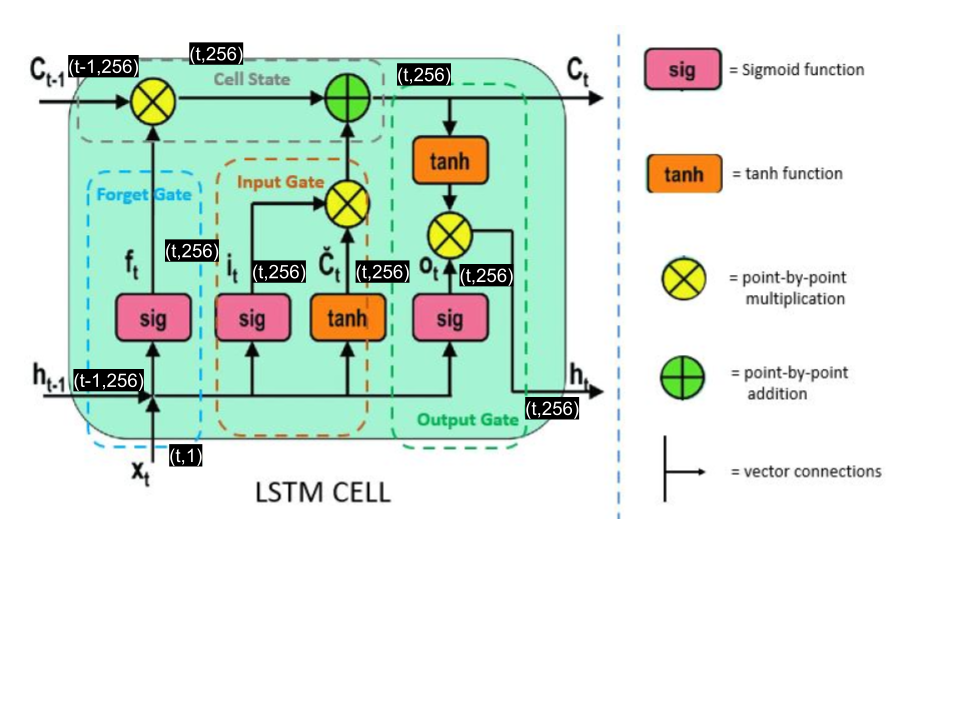

Understand the outputs

In [7]:
class CharModelAnalysis(nn.Module):
  """
  Character-Level Language Model Analysis (for understanding LSTM behavior).

  This class is a variant of the `CharModel` with additional functionalities for analyzing the LSTM's internal states.
  It helps in understanding how the LSTM processes sequences and generates outputs.

  Attributes:
      lstm: An LSTM layer with specified input size, hidden size, number of layers, and dropout rate. This
             LSTM is set to be unidirectional (bidirectional=False).
      linear: A linear layer to map the LSTM output to the vocabulary size (number of characters).
  """

  def __init__(self, n_vocab):
    """
    Initializes the model with an LSTM layer (unidirectional) and a linear layer.

    Args:
        None
    """
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer (unidirectional)
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=2,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2,  # Dropout rate for regularization
        bidirectional=False  # Set to False for unidirectional LSTM
    )

    # Define the linear layer for output
    self.linear = nn.Linear(256, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):
    """
    Defines the forward pass of the model with additional analysis prints.

    Args:
        x: A PyTorch tensor of shape (batch_size, seq_len, features) representing the input sequences.

    Returns:
        A PyTorch tensor of shape (batch_size, vocab_size) containing the model's output logits.
    """

    # Pass the input sequence through the LSTM layer
    x, (h, c) = self.lstm(x)  # Output, final hidden state (h_n), final cell state (c_n)

    # Print the output and hidden state shapes for analysis
    print(x.shape)  # Output features (h_t) for each input of the last layer of the LSTM
    print(h.shape)  # Final hidden state for each layer in the sequence

    # Check if the last element of the output (representing the last hidden state) is equal to the last element of the final hidden state
    # This is generally not true, but can be useful for understanding how the information flows through the LSTM.
    print((x[:, -1, :] == h[-1,:,:]).all())  # Print True/False depending on the equality

    # Take only the last output from the sequence
    x = x[:, -1, :]

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x

# Create an instance of the CharModelAnalysis model
model_analysis = CharModelAnalysis(n_vocab)

# Create a random input tensor (batch size 128, sequence length 100, feature size 1)
inp = torch.randn(128, 100, 1)

# Run the model with the input tensor and get the output
out = model_analysis(inp)


torch.Size([128, 100, 256])
torch.Size([2, 128, 256])
tensor(True)


Train setup and dataloader

In [8]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs
batch_size = 128  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=1  # Predict character by character for testing
)


Train the model

In [9]:
from tqdm.auto import tqdm  # Import tqdm for progress bars

tr_loss_list = []
loss_list= []  # save losses for graphical representation

# Initialize variables for early stopping
best_model = None
best_loss = np.inf  # Initialize with positive infinity
patience = 6  # Number of epochs to wait for improvement before stopping

# Training loop
for epoch in tqdm(range(n_epochs)):
    # Set model to training mode
    model.train()

    train_losses = []
    # Iterate through training batches using the data loader
    for X_batch, y_batch in tqdm(loader_train):
        # Clear gradients from the previous iteration
        optimizer.zero_grad()

        # Get predictions for the current batch
        y_pred = model(X_batch.to(device))

        # Calculate loss for the current batch
        loss = loss_fn(y_pred, y_batch.to(device))
        train_losses.append(loss.cpu().detach().numpy())

        # Calculate the average validation loss
       
        # Backpropagate the loss to calculate gradients
        loss.backward()

        # Update model parameters based on the gradients
        optimizer.step()

    # Validation after each epoch
    model.eval()  # Set model to evaluation mode
    avg_training_loss = np.mean(train_losses)
    tr_loss_list.append(avg_training_loss)
    print("training loss: ", avg_training_loss)
    # List to store validation losses
    validation_losses = []

    # Disable gradient calculation for validation (saves memory)
    with torch.no_grad():
        # Iterate through testing batches
        for X_batch, y_batch in loader_test:
            # Get predictions for the validation batch
            y_pred = model(X_batch.to(device))

            # Calculate validation loss for the current batch
            validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()

            # Append the validation loss to the list
            validation_losses.append(validation_loss)

        # Calculate the average validation loss
        avg_validation_loss = np.mean(validation_losses)

        # Track best model and save if validation loss improves
        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_model = model.state_dict()  # Save the model's state dictionary
            torch.save([best_model, char_to_int], "single-charLSTM_2layers.pth")  # Save model and character mapping
            patience = 6  # Reset patience counter for early stopping
            print("**BEST**", end="")  # Print indicator for best model
        else:
            patience -= 1  # Decrement patience counter if validation loss doesn't improve

        # Print epoch information and validation loss
        print("Epoch %d: Cross-entropy: %.4f" % (epoch +1, avg_validation_loss))
        loss_list.append(avg_validation_loss)
        # Implement early stopping
        if patience <= 0:
            print("Stop training!")
            break


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.6911235
**BEST**Epoch 1: Cross-entropy: 2.6706


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.2719593
**BEST**Epoch 2: Cross-entropy: 2.4634


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.0340495
**BEST**Epoch 3: Cross-entropy: 2.3845


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.8861572
**BEST**Epoch 4: Cross-entropy: 2.3394


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.7813332
**BEST**Epoch 5: Cross-entropy: 2.3096


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.7000879
**BEST**Epoch 6: Cross-entropy: 2.2960


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.6316735
**BEST**Epoch 7: Cross-entropy: 2.2743


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.5733054
**BEST**Epoch 8: Cross-entropy: 2.2716


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.522192
Epoch 9: Cross-entropy: 2.2886


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.4777814
Epoch 10: Cross-entropy: 2.2833


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.4368622
Epoch 11: Cross-entropy: 2.2772


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3978314
Epoch 12: Cross-entropy: 2.2947


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3645418
Epoch 13: Cross-entropy: 2.3230


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3314093
Epoch 14: Cross-entropy: 2.3429
Stop training!


3. Generate text with the model


Training loss minimum: 1.3314093
Validation loss minimum: 2.271618


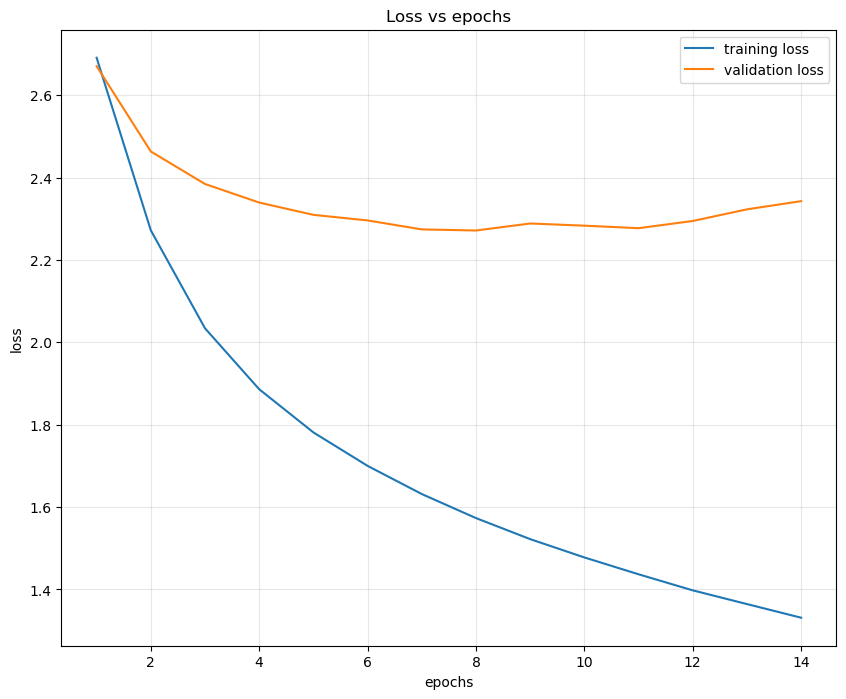

In [14]:
Print_loss(tr_loss_list,loss_list)

In [15]:
import numpy as np
import torch
import torch.nn as nn

# Load the best model and character mapping dictionary
best_model, char_to_int = torch.load("single-char.pth")

# Get vocabulary size from the character mapping dictionary
n_vocab = len(char_to_int)

# Create a dictionary for converting integer indices back to characters
int_to_char = dict((i, c) for c, i in char_to_int.items())

# Create a model instance and load the weights from the saved model
model = CharModel(n_vocab)
model.load_state_dict(best_model)
model.to(device)  # Move the model to the appropriate device (CPU or GPU)

# Generate random starting indices
starts = np.random.randint(0, len(raw_text)-seq_length, 10)

# Set model to evaluation mode (no gradients needed during generation)
model.eval()

# Text Generation Loop
for s in starts:
  # Extract the prompt (sequence of characters) based on the starting index
  prompt = raw_text[s:s+seq_length]

  # Convert the characters in the prompt to integer indices using the character mapping dictionary
  pattern = [char_to_int[c] for c in prompt]

  print(f"Sequence {s}")
  print('\tPrompt: "%s"' % prompt)
  print("\tGenerated: ", end="")

  with torch.no_grad():  # Disable gradient calculation for efficiency
    for i in range(500):
      # Prepare the input for the model:
      #   - Reshape the pattern list into a PyTorch tensor with dimensions (1, sequence_length, 1)
      #   - Normalize the input by dividing by the vocabulary size (n_vocab)
      #   - Convert the NumPy array to a PyTorch tensor with float32 data type
      x = np.reshape(pattern, (1, len(pattern), 1)) / float(n_vocab)
      x = torch.tensor(x, dtype=torch.float32)

      # Move the input tensor to the device (CPU or GPU)
      x = x.to(device)

      # Generate logits using the model
      prediction = model(x)

      # Get the index of the predicted character with the highest probability
      index = int(prediction.argmax())
      result = int_to_char[index]

      # Print the generated character
      print(result, end="")

      # Update the pattern for the next iteration:
      #   - Append the predicted character index to the pattern list
      #   - Slice the pattern list to keep the most recent sequence length characters
      pattern.append(index)
      pattern = pattern[1:]
  print("\n")
print("Done")

Sequence 130932
	Prompt: "   involved in this affair he trusts to you to set them free     exactly as we were  my notion was t"
	Generated: he mock turtle went on would be a large right size and the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the q

Sequence 67869
	Prompt: "as it was in march as she said this she looked up and there was the cat again sitting on a branch of"
	Generated:  the words was the mock turtle went on would be a large right size and the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the queen the quee

**ASSIGNMENT**

Modify the LSTM network with [RNN or GRU](https://pytorch.org/docs/stable/nn.html#recurrent-layers)  and analyze the results exploring variations in the number of layers, hidden state dimensions, dropout rates, and other relevant parameters.

## Three layers LSTM

In [28]:
class CharModel(nn.Module):
  """
  Character-Level Language Model using LSTM.

  This class defines a recurrent neural network (RNN) model with a Long Short-Term Memory (LSTM) layer
  for character-level language modeling.

  Attributes:
      lstm: An LSTM layer with specified input size, hidden size, number of layers, and dropout rate.
      linear: A linear layer to map the LSTM output to the vocabulary size (number of characters).
  """

  def __init__(self, n_vocab):
    """
    Initializes the model with an LSTM layer and a linear layer.

    Args:
        None
    """
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=3,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2  # Dropout rate for regularization
    )

    # Define the linear layer for output
    self.linear = nn.Linear(256, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x: A PyTorch tensor of shape (batch_size, seq_len, features) representing the input sequences.

    Returns:
        A PyTorch tensor of shape (batch_size, vocab_size) containing the model's output logits.
    """

    # Pass the input sequence through the LSTM layer
    # The output (`x`) will be a tuple containing the output tensor and the hidden/cell states (not used here)
    x, _ = self.lstm(x)

    # Print the output shape for debugging purposes (can be commented out)
    # print(x.shape)

    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [31]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs
batch_size = 128  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=1  # Predict character by character for testing
)


In [32]:
from tqdm.auto import tqdm  # Import tqdm for progress bars

tr_loss_list = []
loss_list= []  # save losses for graphical representation

# Initialize variables for early stopping
best_model = None
best_loss = np.inf  # Initialize with positive infinity
patience = 6  # Number of epochs to wait for improvement before stopping

# Training loop
for epoch in tqdm(range(n_epochs)):
    # Set model to training mode
    model.train()

    train_losses = []
    # Iterate through training batches using the data loader
    for X_batch, y_batch in tqdm(loader_train):
        # Clear gradients from the previous iteration
        optimizer.zero_grad()

        # Get predictions for the current batch
        y_pred = model(X_batch.to(device))

        # Calculate loss for the current batch
        loss = loss_fn(y_pred, y_batch.to(device))
        train_losses.append(loss.cpu().detach().numpy())

        # Calculate the average validation loss
       
        # Backpropagate the loss to calculate gradients
        loss.backward()

        # Update model parameters based on the gradients
        optimizer.step()

    # Validation after each epoch
    model.eval()  # Set model to evaluation mode
    avg_training_loss = np.mean(train_losses)
    tr_loss_list.append(avg_training_loss)
    print("training loss: ", avg_training_loss)
    # List to store validation losses
    validation_losses = []

    # Disable gradient calculation for validation (saves memory)
    with torch.no_grad():
        # Iterate through testing batches
        for X_batch, y_batch in loader_test:
            # Get predictions for the validation batch
            y_pred = model(X_batch.to(device))

            # Calculate validation loss for the current batch
            validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()

            # Append the validation loss to the list
            validation_losses.append(validation_loss)

        # Calculate the average validation loss
        avg_validation_loss = np.mean(validation_losses)

        # Track best model and save if validation loss improves
        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_model = model.state_dict()  # Save the model's state dictionary
            torch.save([best_model, char_to_int], "single-charLSTM_3layers.pth")  # Save model and character mapping
            patience = 6  # Reset patience counter for early stopping
            print("**BEST**", end="")  # Print indicator for best model
        else:
            patience -= 1  # Decrement patience counter if validation loss doesn't improve

        # Print epoch information and validation loss
        print("Epoch %d: Cross-entropy: %.4f" % (epoch +1, avg_validation_loss))
        loss_list.append(avg_validation_loss)
        # Implement early stopping
        if patience <= 0:
            print("Stop training!")
            break


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.6380386
**BEST**Epoch 1: Cross-entropy: 2.5439


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.1215417
**BEST**Epoch 2: Cross-entropy: 2.3735


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.8921392
**BEST**Epoch 3: Cross-entropy: 2.2678


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.7545394
**BEST**Epoch 4: Cross-entropy: 2.2295


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.6504881
**BEST**Epoch 5: Cross-entropy: 2.1952


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.5725
**BEST**Epoch 6: Cross-entropy: 2.1862


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.5058539
**BEST**Epoch 7: Cross-entropy: 2.1815


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.4522251
**BEST**Epoch 8: Cross-entropy: 2.1707


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.4046417
Epoch 9: Cross-entropy: 2.2119


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3634763
Epoch 10: Cross-entropy: 2.2184


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3232061
Epoch 11: Cross-entropy: 2.2061


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.2882504
Epoch 12: Cross-entropy: 2.2185


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.2578099
Epoch 13: Cross-entropy: 2.2491


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.2272086
Epoch 14: Cross-entropy: 2.3166
Stop training!


Training loss minimum: 1.2272086
Validation loss minimum: 2.1707456


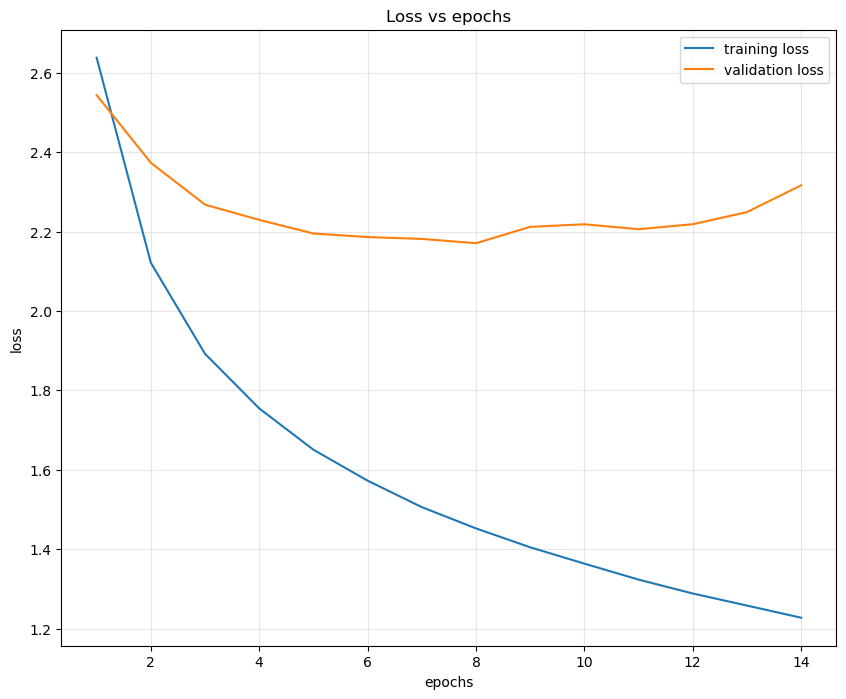

In [33]:
Print_loss(tr_loss_list,loss_list)

## 4 Layers LSTM


In [45]:
class CharModel(nn.Module):
  """
  Character-Level Language Model using LSTM.

  This class defines a recurrent neural network (RNN) model with a Long Short-Term Memory (LSTM) layer
  for character-level language modeling.

  Attributes:
      lstm: An LSTM layer with specified input size, hidden size, number of layers, and dropout rate.
      linear: A linear layer to map the LSTM output to the vocabulary size (number of characters).
  """

  def __init__(self, n_vocab):
    """
    Initializes the model with an LSTM layer and a linear layer.

    Args:
        None
    """
    super().__init__()  # Call the superclass constructor

    # Define the LSTM layer
    self.lstm = nn.LSTM(
        input_size=1,  # Input size: one-hot encoded characters (represented as floats here)
        hidden_size=256,  # Hidden size of the LSTM layer
        num_layers=4,  # Number of LSTM layers stacked on top of each other
        batch_first=True,  # Input tensors are of shape (batch_size, seq_len, features)
        dropout=0.2  # Dropout rate for regularization
    )

    # Define the linear layer for output
    self.linear = nn.Linear(256, n_vocab)  # Map LSTM output to vocabulary size (number of characters)

  def forward(self, x):
    """
    Defines the forward pass of the model.

    Args:
        x: A PyTorch tensor of shape (batch_size, seq_len, features) representing the input sequences.

    Returns:
        A PyTorch tensor of shape (batch_size, vocab_size) containing the model's output logits.
    """

    # Pass the input sequence through the LSTM layer
    # The output (`x`) will be a tuple containing the output tensor and the hidden/cell states (not used here)
    x, _ = self.lstm(x)

    # Print the output shape for debugging purposes (can be commented out)
    # print(x.shape)

    # Take only the last output from the sequence (represents the model's prediction based on the entire sequence)
    x = x[:, -1, :]  # Select the last element from the sequence dimension

    # Pass the LSTM output through the linear layer to get logits for the next character prediction
    x = self.linear(x)

    return x


In [46]:
# Hyperparameters for training
n_epochs = 60  # Number of training epochs
batch_size = 128  # Batch size for training

# Move the model to the appropriate device (CPU or GPU)
model = CharModel(n_vocab)
model.to(device)

# Define optimizer for training (Adam optimizer with learning rate adjustment)
optimizer = optim.Adam(model.parameters())

# Define loss function (CrossEntropyLoss for character-level prediction)
loss_fn = nn.CrossEntropyLoss()

# Create training data loader
loader_train = data.DataLoader(
    data.TensorDataset(X_train, y_train),  # Dataset containing input sequences and target characters
    shuffle=True,  # Shuffle the data for each epoch
    batch_size=batch_size  # Batch size for training
)

# Create testing data loader (without shuffling and with batch size 1 for character-by-character prediction)
loader_test = data.DataLoader(
    data.TensorDataset(X_test, y_test),
    shuffle=False,  # Don't shuffle testing data
    batch_size=1  # Predict character by character for testing
)


In [47]:

tr_loss_list = []
loss_list= []  # save losses for graphical representation

# Initialize variables for early stopping
best_model = None
best_loss = np.inf  # Initialize with positive infinity
patience = 6  # Number of epochs to wait for improvement before stopping

# Training loop
for epoch in tqdm(range(n_epochs)):
    # Set model to training mode
    model.train()

    train_losses = []
    # Iterate through training batches using the data loader
    for X_batch, y_batch in tqdm(loader_train):
        # Clear gradients from the previous iteration
        optimizer.zero_grad()

        # Get predictions for the current batch
        y_pred = model(X_batch.to(device))

        # Calculate loss for the current batch
        loss = loss_fn(y_pred, y_batch.to(device))
        train_losses.append(loss.cpu().detach().numpy())

        # Calculate the average validation loss
       
        # Backpropagate the loss to calculate gradients
        loss.backward()

        # Update model parameters based on the gradients
        optimizer.step()

    # Validation after each epoch
    model.eval()  # Set model to evaluation mode
    avg_training_loss = np.mean(train_losses)
    tr_loss_list.append(avg_training_loss)
    print("training loss: ", avg_training_loss)
    # List to store validation losses
    validation_losses = []

    # Disable gradient calculation for validation (saves memory)
    with torch.no_grad():
        # Iterate through testing batches
        for X_batch, y_batch in loader_test:
            # Get predictions for the validation batch
            y_pred = model(X_batch.to(device))

            # Calculate validation loss for the current batch
            validation_loss = loss_fn(y_pred.to(device), y_batch.to(device)).cpu()

            # Append the validation loss to the list
            validation_losses.append(validation_loss)

        # Calculate the average validation loss
        avg_validation_loss = np.mean(validation_losses)

        # Track best model and save if validation loss improves
        if avg_validation_loss < best_loss:
            best_loss = avg_validation_loss
            best_model = model.state_dict()  # Save the model's state dictionary
            torch.save([best_model, char_to_int], "single-charLSTM_4layers.pth")  # Save model and character mapping
            patience = 6  # Reset patience counter for early stopping
            print("**BEST**", end="")  # Print indicator for best model
        else:
            patience -= 1  # Decrement patience counter if validation loss doesn't improve

        # Print epoch information and validation loss
        print("Epoch %d: Cross-entropy: %.4f" % (epoch +1, avg_validation_loss))
        loss_list.append(avg_validation_loss)
        # Implement early stopping
        if patience <= 0:
            print("Stop training!")
            break


  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.8078916
**BEST**Epoch 1: Cross-entropy: 2.8239


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  2.284746
**BEST**Epoch 2: Cross-entropy: 2.3754


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.9032711
**BEST**Epoch 3: Cross-entropy: 2.2419


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.7265795
**BEST**Epoch 4: Cross-entropy: 2.1734


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.6088296
**BEST**Epoch 5: Cross-entropy: 2.1447


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.5239913
Epoch 6: Cross-entropy: 2.1755


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.45486
**BEST**Epoch 7: Cross-entropy: 2.1438


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3952425
**BEST**Epoch 8: Cross-entropy: 2.1261


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3481019
Epoch 9: Cross-entropy: 2.1303


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.3028347
Epoch 10: Cross-entropy: 2.1504


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.2668287
Epoch 11: Cross-entropy: 2.1645


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.2266488
Epoch 12: Cross-entropy: 2.1763


  0%|          | 0/846 [00:00<?, ?it/s]

training loss:  1.1891537


KeyboardInterrupt: 

In [4]:
import numpy as np


Training loss minimum: 1.7453502
Validation loss minimum: 2.4424984


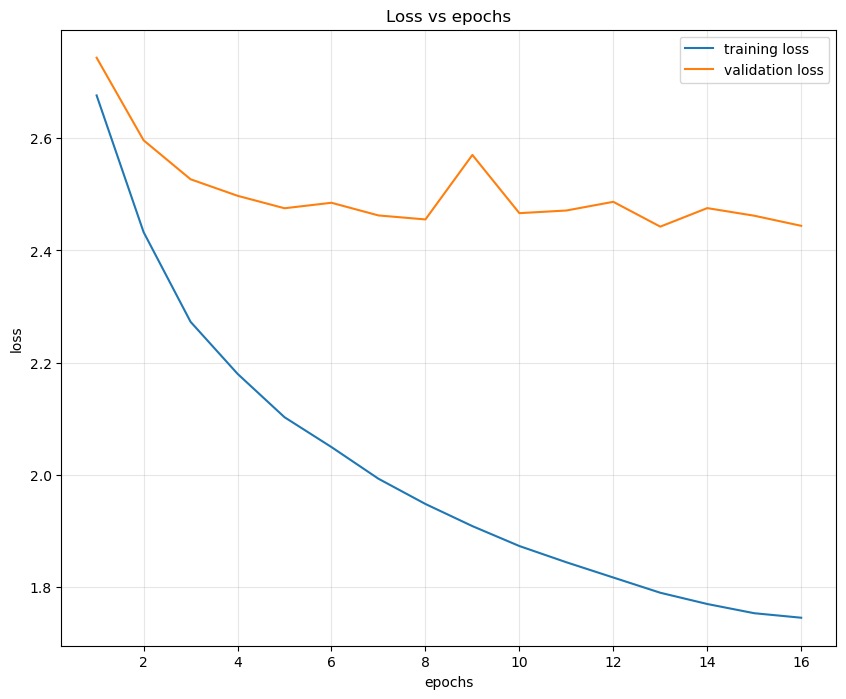

In [7]:
Print_loss(tr_loss=l1[0:16],tst_loss=l2[0:16])

In [2]:
l1 =[2.6763966,
  2.432706,
  2.2728362,
  2.1801739,
  2.1027775,
  2.0495257,
  1.9931182,
  1.9481138,
  1.9086448,
  1.873145,
  1.8442335,
  1.8170239,
  1.7898829,
  1.769813,
  1.7533981,
  1.7453502,
  1.7310508,
  2.481387,
  2.8433356]
l2= [2.7436109,
  2.596414,
  2.5269408,
  2.4975054,
  2.4752653,
  2.4850533,
  2.462471,
  2.4553401,
  2.57032,
  2.4665375,
  2.4712417,
  2.4867456,
  2.4424984,
  2.4755216,
  2.4619803,
  2.4439695,
  2.4856374,
  2.9319649,
  2.904792]